# Algorithm for segmentation and index extraction

## Image segmentation

In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

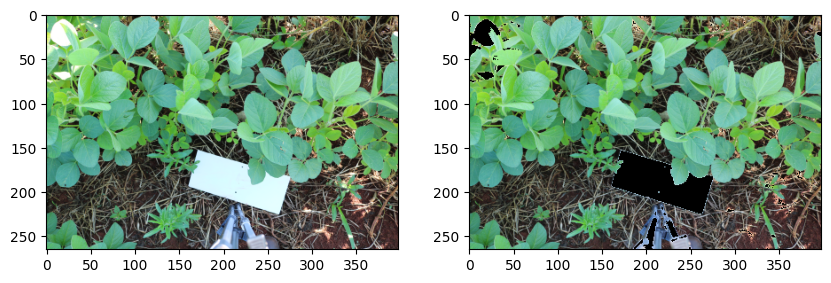

In [10]:
# Opening and displaying image

image = cv2.imread("./../ImagesandMap/2Amostragem/IMG_4117.JPG", cv2.IMREAD_COLOR)

scale_percent = 10 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# Resize image
resizedImage = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
RGB_image = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2RGB)

# Creating segmented image
hsv = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2HSV)

lower = np.array([35, 0, 0])
upper = np.array([85, 255, 255])

mask = cv2.inRange(hsv, lower, upper)

masked = cv2.bitwise_and(hsv, hsv, mask=mask)

newImage = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)

# Plot images
rows = 1
columns = 2
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(rows, columns, 1)

plt.imshow(RGB_image)

fig.add_subplot(rows, columns, 2)
plt.imshow(newImage)

## Extracting indexes and saving the values in a csv file

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pandas as pd

### Single image

In [11]:
def resizeAndSegment(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)

    scale_percent = 10 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    resizedImage = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    hsv = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2HSV)

    lower = np.array([35, 0, 0])
    upper = np.array([85, 255, 255])

    mask = cv2.inRange(hsv, lower, upper)

    masked = cv2.bitwise_and(hsv, hsv, mask=mask)

    newImage = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)
    return(newImage)

def resizeAndTakeWhiteOff(path):
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)

    scale_percent = 10 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    resizedImage = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


    lower = np.array([0, 0, 0])
    upper = np.array([240, 240, 240])

    mask = cv2.inRange(resizedImage, lower, upper)

    masked = cv2.bitwise_and(resizedImage, resizedImage, mask=mask)

    newImage = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
    return(newImage)

def generatingIndexes(image):
    B, G, R = cv2.split(image) 
    meanG = np.mean(G, axis=None) 
    meanR = np.mean(R, axis=None)
    meanB = np.mean(B, axis=None)
    mean1G = meanG/255
    mean1R = meanR/255
    mean1B = meanB/255
    if max(meanG,meanR, meanB) == meanR:
        H = 60*((mean1G-mean1B)/(max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B)))  if (max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B)) != 0 else 0
    if max(meanG,meanR, meanB) == meanG:
        H = 60*(2+((mean1B-mean1R)/(max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B))))  if (max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B)) != 0 else 0
    if max(meanG,meanR, meanB) == meanB:
            H = 60*(4+((mean1R-mean1G)/(max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B))))  if (max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B)) != 0 else 0
    S = (max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B))/max(mean1G,mean1R, mean1B)  if (max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B)) != 0 else 0
    V = max(mean1G,mean1R, mean1B)
    MPRI = (meanG - meanR)/(meanG + meanR) 
    Gn = (meanG)/(meanG + meanR + meanB) 
    Rn = (meanR)/(meanG + meanR + meanB) 
    Bn = (meanB)/(meanG + meanR + meanB)
    ICVE = ((H - 60)/60 + (1-S)+(1-V))/3
    res = [Rn, Gn, Bn, MPRI, H, S, V, ICVE]
    return(res)

In [5]:
print(generatingIndexes(resizeAndSegment("./../ImagesandMap/4Amostragem/IMG_4402.JPG")))

[0.22309666920229268, 0.441549544195273, 0.3353537866024342, 0.32867542248722664, 150.83240284306135, 0.4947414800101586, 0.46717706177948565, 0.8506516129760149]


In [12]:
print(generatingIndexes(resizeAndTakeWhiteOff("./../ImagesandMap/4Amostragem/IMG_4402.JPG")))

[0.22452226076805334, 0.4395072622956143, 0.3359704769363322, 0.32375819758084473, 151.1039975932436, 0.4891500550062839, 0.46995856083971466, 0.853097114680465]


### All the folders

#### Image segmented

In [11]:
# Creating the empty array
indices = []

# Creating loop to enter in each folder
for root, dirs, files in os.walk("./../ImagesandMap/"):
    for name in files:
        if name.endswith('.JPG'):
            path = os.path.join(root, name)
            indexes = generatingIndexes(resizeAndSegment(str(path)))
            print(indexes)
            indices.append(indexes)

# Creating the database
df = pd.DataFrame(indices, columns = ['Rn', 'Gn', 'Bn', 'MPRI', 'H', 'S', 'V', 'ICVE'])
df.index = df.index + 1

# Saving as csv file
cvs_file = df.to_csv("VisibleIndices.csv")

[0.2745917212760714, 0.4265806342198915, 0.2988276445040371, 0.21676398356622775, 129.56750966575729, 0.35629585769117145, 0.14963991247394948, 0.8845075747547223]
[0.2399175126840052, 0.44392984158045257, 0.3161526457355422, 0.29833021598201814, 142.4207429415403, 0.4595598443441757, 0.19791989916285088, 0.9053997685062151]
[0.2087429391952828, 0.44142378870724286, 0.34983327209747433, 0.3578787402157621, 156.38210876351627, 0.5271144316743577, 0.1746204942581944, 0.9682111844864619]
[0.20840729607305153, 0.44324689240054627, 0.34834581152640215, 0.36037456749502567, 155.7533868159609, 0.529816678591124, 0.19815626411747975, 0.9559722791858037]
[0.21492322610856882, 0.4417201807050011, 0.3433565931864301, 0.34538830702190093, 153.97753747789037, 0.5134403282966521, 0.25273489162423285, 0.9333723571257626]
[0.21984085341468879, 0.4362722488814208, 0.3438868977038904, 0.3298690343316062, 154.3885536629372, 0.4960925110906109, 0.1206331695473297, 0.9854722934703375]
[0.21285507532199585,

#### Images not segmented

In [13]:
# Creating the empty array
indices = []

# Creating loop to enter in each folder
for root, dirs, files in os.walk("./../ImagesandMap/"):
    for name in files:
        if name.endswith('.JPG'):
            path = os.path.join(root, name)
            indexes = generatingIndexes(resizeAndSegment(str(path)))
            print(indexes)
            indices.append(indexes)

# Creating the database
df = pd.DataFrame(indices, columns = ['Rn', 'Gn', 'Bn', 'MPRI', 'H', 'S', 'V', 'ICVE'])
df.index = df.index + 1

# Saving as csv file
cvs_file = df.to_csv("VisibleIndicesNotSegmented.csv")

[0.2745917212760714, 0.4265806342198915, 0.2988276445040371, 0.21676398356622775, 129.56750966575729, 0.35629585769117145, 0.14963991247394948, 0.8845075747547223]
[0.2399175126840052, 0.44392984158045257, 0.3161526457355422, 0.29833021598201814, 142.4207429415403, 0.4595598443441757, 0.19791989916285088, 0.9053997685062151]
[0.2087429391952828, 0.44142378870724286, 0.34983327209747433, 0.3578787402157621, 156.38210876351627, 0.5271144316743577, 0.1746204942581944, 0.9682111844864619]
[0.20840729607305153, 0.44324689240054627, 0.34834581152640215, 0.36037456749502567, 155.7533868159609, 0.529816678591124, 0.19815626411747975, 0.9559722791858037]
[0.21492322610856882, 0.4417201807050011, 0.3433565931864301, 0.34538830702190093, 153.97753747789037, 0.5134403282966521, 0.25273489162423285, 0.9333723571257626]
[0.21984085341468879, 0.4362722488814208, 0.3438868977038904, 0.3298690343316062, 154.3885536629372, 0.4960925110906109, 0.1206331695473297, 0.9854722934703375]
[0.21285507532199585,